## 1. Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 2. Read The Training Data

In [2]:
file_path = r"C:\Users\admin\OneDrive\Desktop\Flights_SageMaker_Project\Data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-06,Delhi,Cochin,14:20:00,22:30,490,1.0,No Info,6938
1,Multiple Carriers,2019-06-15,Delhi,Cochin,11:30:00,19:15,465,1.0,No Info,16108
2,Jet Airways,2019-05-12,Kolkata,Banglore,17:00:00,22:05,1745,1.0,No Info,13067
3,Air India,2019-05-09,Delhi,Cochin,14:25:00,19:15,1730,2.0,No Info,13591
4,Air India,2019-03-06,Mumbai,Hyderabad,12:45:00,19:25,1840,2.0,No Info,13253
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-05-18,Delhi,Cochin,10:20:00,19:00,520,1.0,No Info,9794
636,Jet Airways,2019-05-21,Delhi,Cochin,08:00:00,04:25,1225,1.0,In-flight meal not included,12898
637,Jet Airways,2019-05-24,Kolkata,Banglore,09:35:00,09:45,1450,1.0,No Info,13067
638,Indigo,2019-06-12,Banglore,Delhi,07:10:00,10:05,175,0.0,No Info,4823


In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
    
    col: pd.to_datetime(train.loc[:,col], format ="mixed")
    for col in ['date_of_journey','dep_time','arrival_time']
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## 3.High Level Sumamry of Data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [6]:
train.describe(include=[int,float])

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,638.132812,0.800000,8742.960938
std,512.107850,0.699206,4153.599984
min,80.000000,0.000000,1965.000000
25%,170.000000,0.000000,5041.500000
50%,497.500000,1.000000,8021.000000
75%,965.000000,1.000000,11982.000000
max,2565.000000,4.000000,27430.000000


>- Average flights duration is 638 min --> 10 hrs
>- Duratio has most highest value as of 2565 minutes means it has very large range.

In [7]:
train.describe(include='O')

,airline,source,destination,additional_info
count,640,640,640,640
unique,8,5,6,4
top,Jet Airways,Delhi,Cochin,No Info
freq,206,262,262,500


In [8]:
(
    train
    .assign(
        total_stops=train['total_stops'].astype(object)
    )
    .describe(include='O')
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,5.0,4
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,206,262,262,322.0,500


In [9]:
!pip install statsmodels

In [10]:
import eda_helper_functions

## 4. High Level Analysis of Missing Values

In [11]:
train.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

In [12]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


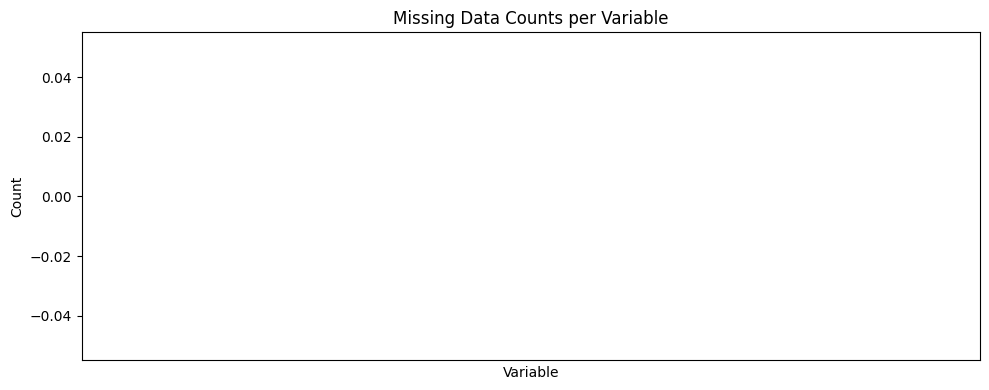

In [13]:
eda_helper_functions.plot_missing_info(train)

## 5. High Level Analysis of outlier

### Isolation Forest

>- So It is Ensemble learning algorithm were used for detecting the outliers.
>- As we have multiple sub Decision tress.
>- So first it selects random Numeric feature and select random value and perform split over it.
>- After splitting on that it will isolate the anomaly immediately because they are different from the majority of the data.
>- Further it will perform over each subtree and defines a tree.
>- Finally it takes an average of all trees at which depth like level 1 or 2 or 3 outliers are captured that will be the score.
>- Based on that score it will return -1 or 1.
>- -1 is an outlier and 1 is not an outlier.

In [14]:
from sklearn.ensemble import IsolationForest

In [15]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [16]:
(
    train
    .assign(outlier=forest.fit_predict(train
                            .drop(columns='price')
                            .select_dtypes(include='number')
                          ))
    .query('outlier == -1')
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
2,Jet Airways,2019-05-12,Kolkata,Banglore,2024-06-25 17:00:00,2024-06-25 22:05:00,1745,1.0,No Info,13067,-1
3,Air India,2019-05-09,Delhi,Cochin,2024-06-25 14:25:00,2024-06-25 19:15:00,1730,2.0,No Info,13591,-1
4,Air India,2019-03-06,Mumbai,Hyderabad,2024-06-25 12:45:00,2024-06-25 19:25:00,1840,2.0,No Info,13253,-1
5,Air India,2019-03-01,Delhi,Cochin,2024-06-25 09:45:00,2024-06-25 08:15:00,1350,1.0,No Info,22798,-1
7,Jet Airways,2019-05-15,Kolkata,Banglore,2024-06-25 16:30:00,2024-06-25 12:00:00,1170,1.0,In-flight meal not included,10844,-1
...,...,...,...,...,...,...,...,...,...,...,...
617,Air India,2019-06-12,Delhi,Cochin,2024-06-25 09:45:00,2024-06-25 08:15:00,1350,1.0,No Info,8991,-1
619,Jet Airways,2019-06-24,Delhi,Cochin,2024-06-25 20:55:00,2024-06-25 19:00:00,1325,1.0,In-flight meal not included,10262,-1
620,Air India,2019-06-09,Kolkata,Banglore,2024-06-25 09:10:00,2024-06-25 13:15:00,245,1.0,No Info,8996,-1
630,Air India,2019-05-01,Kolkata,Banglore,2024-06-25 09:25:00,2024-06-25 18:20:00,535,2.0,No Info,8366,-1


## 6. Pair Plots

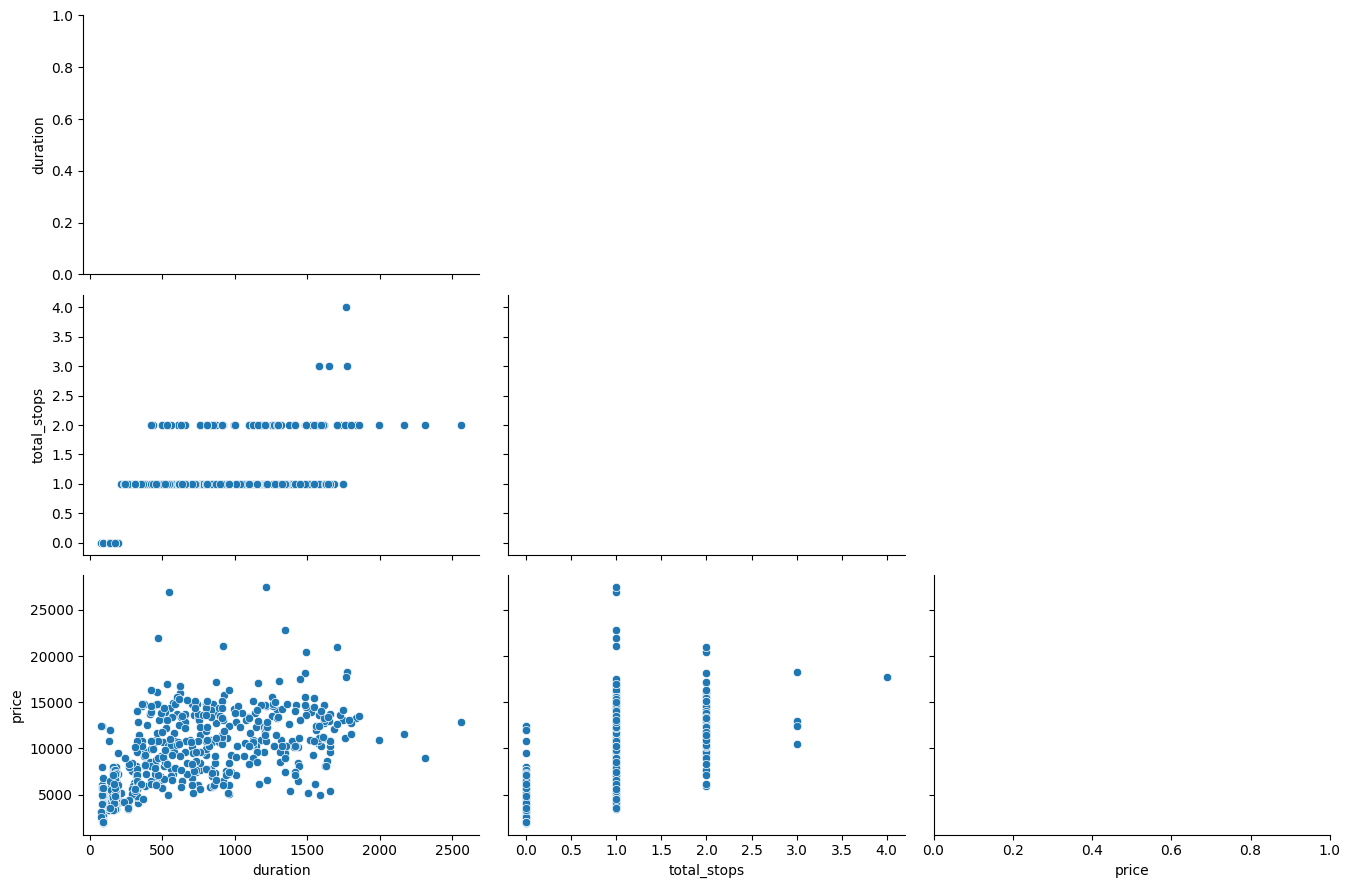

In [17]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

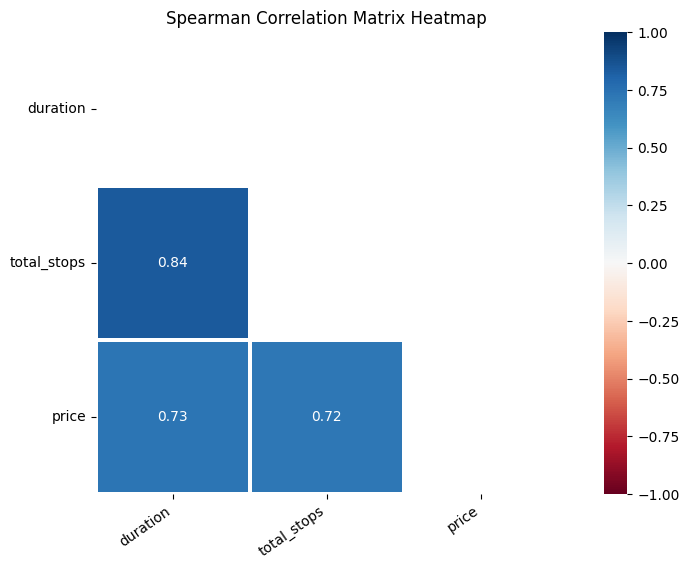

In [18]:
eda_helper_functions.correlation_heatmap(train)

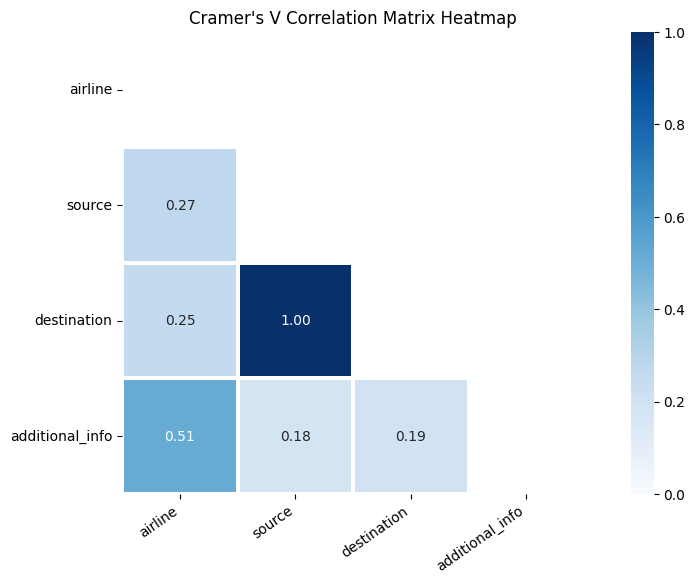

In [19]:
eda_helper_functions.cramersV_heatmap(train)

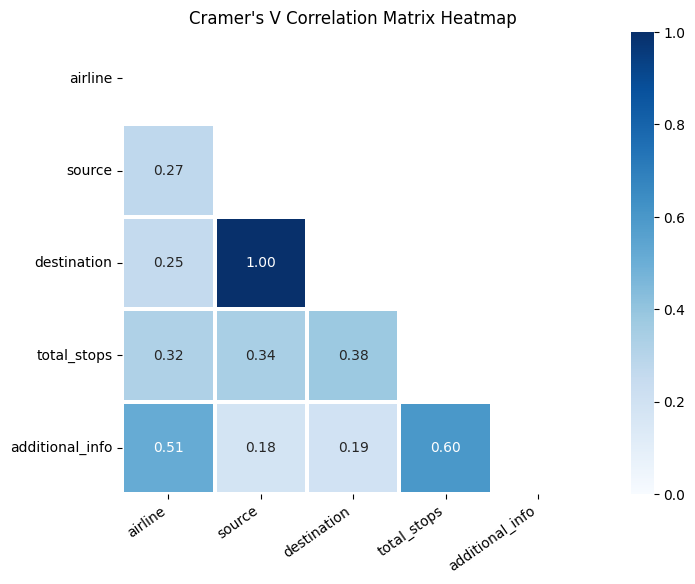

In [20]:
eda_helper_functions.cramersV_heatmap(train.assign(
                                        total_stops=train.total_stops.astype('O')
))

## 8. Detailed Analysis

In [21]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

<Axes: ylabel='count'>

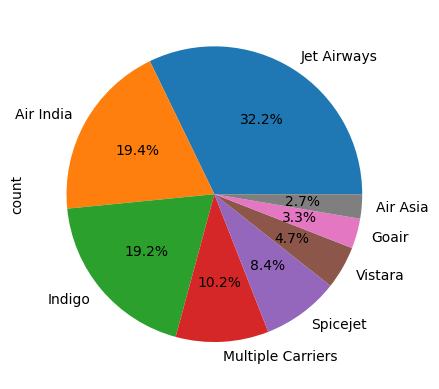

In [22]:
(
    train
    .airline
    .value_counts()
    .plot.pie(autopct='%1.1f%%')
)

In [23]:
eda_helper_functions.cat_summary(train,'airline')

0                 Indigo
1      Multiple Carriers
2            Jet Airways
3              Air India
4              Air India
             ...        
635    Multiple Carriers
636          Jet Airways
637          Jet Airways
638               Indigo
639          Jet Airways
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,206


,count,percentage
category,,
Jet Airways,206,0.321875
Air India,124,0.193750
Indigo,123,0.192188
Multiple Carriers,65,0.101562
Spicejet,54,0.084375
Vistara,30,0.046875
Goair,21,0.032813
Air Asia,17,0.026562


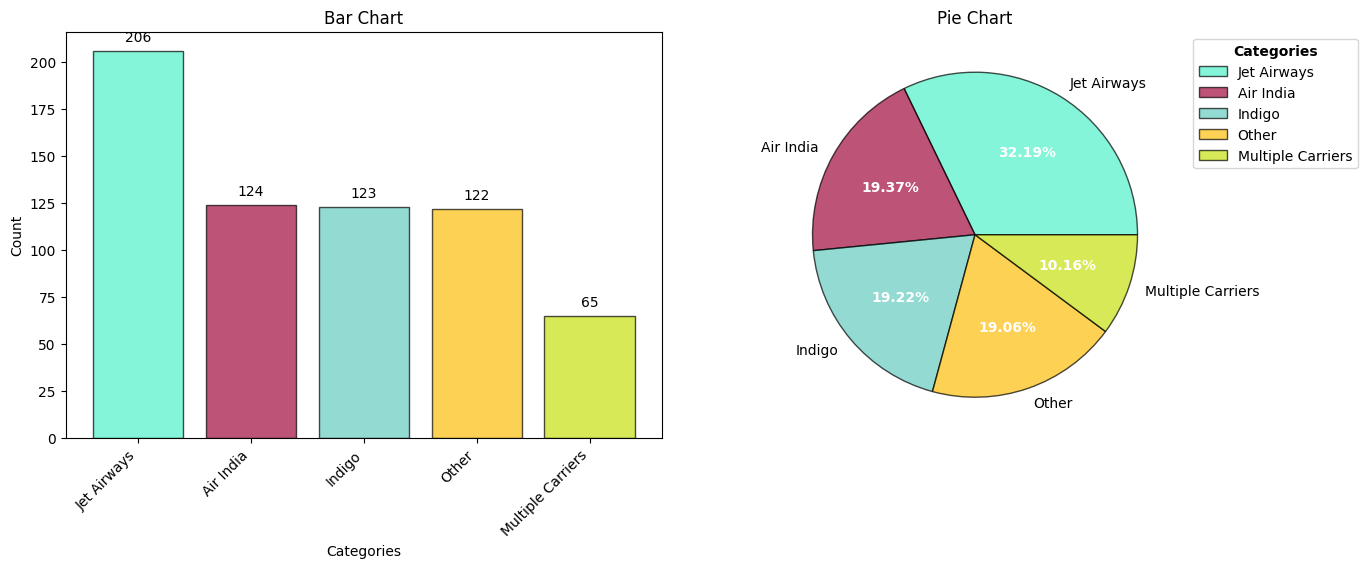

In [24]:
eda_helper_functions.cat_univar_plots(train,'airline',show_wordcloud=False,k=4,figsize=(14,10))

>- Inside that function we can suply k value means we are supplying values of categories we wants so it takes only high cardinal catgories and rare categories would be trated as 1

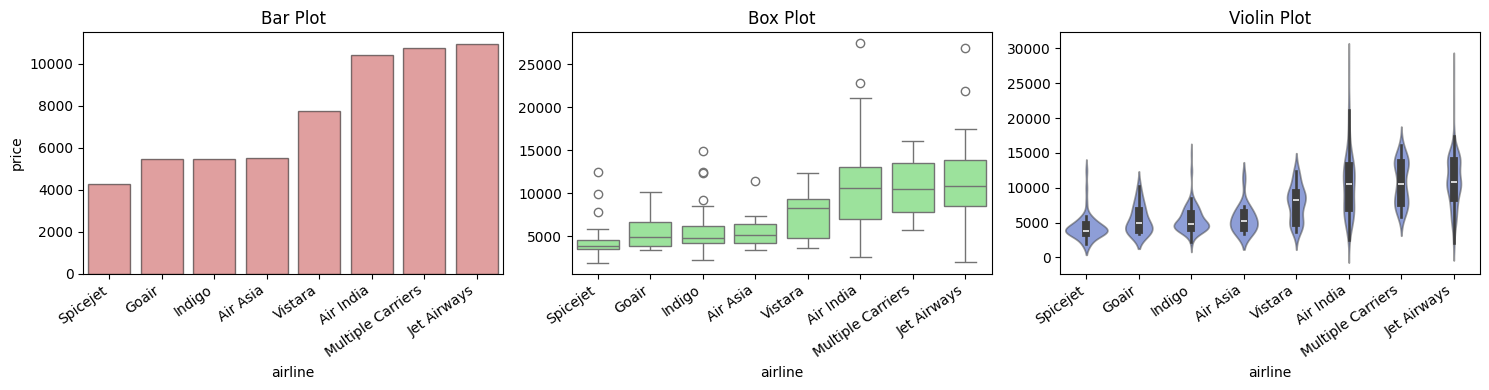

In [25]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var='price',
    cat_var='airline'
)

In [26]:
eda_helper_functions.num_cat_hyp_testing(train, 'price', 'airline')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 61.63547401674187
- p-value              : 2.2049914454652257e-67
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 302.53473734252435
- p-value              : 1.739372458643641e-61
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


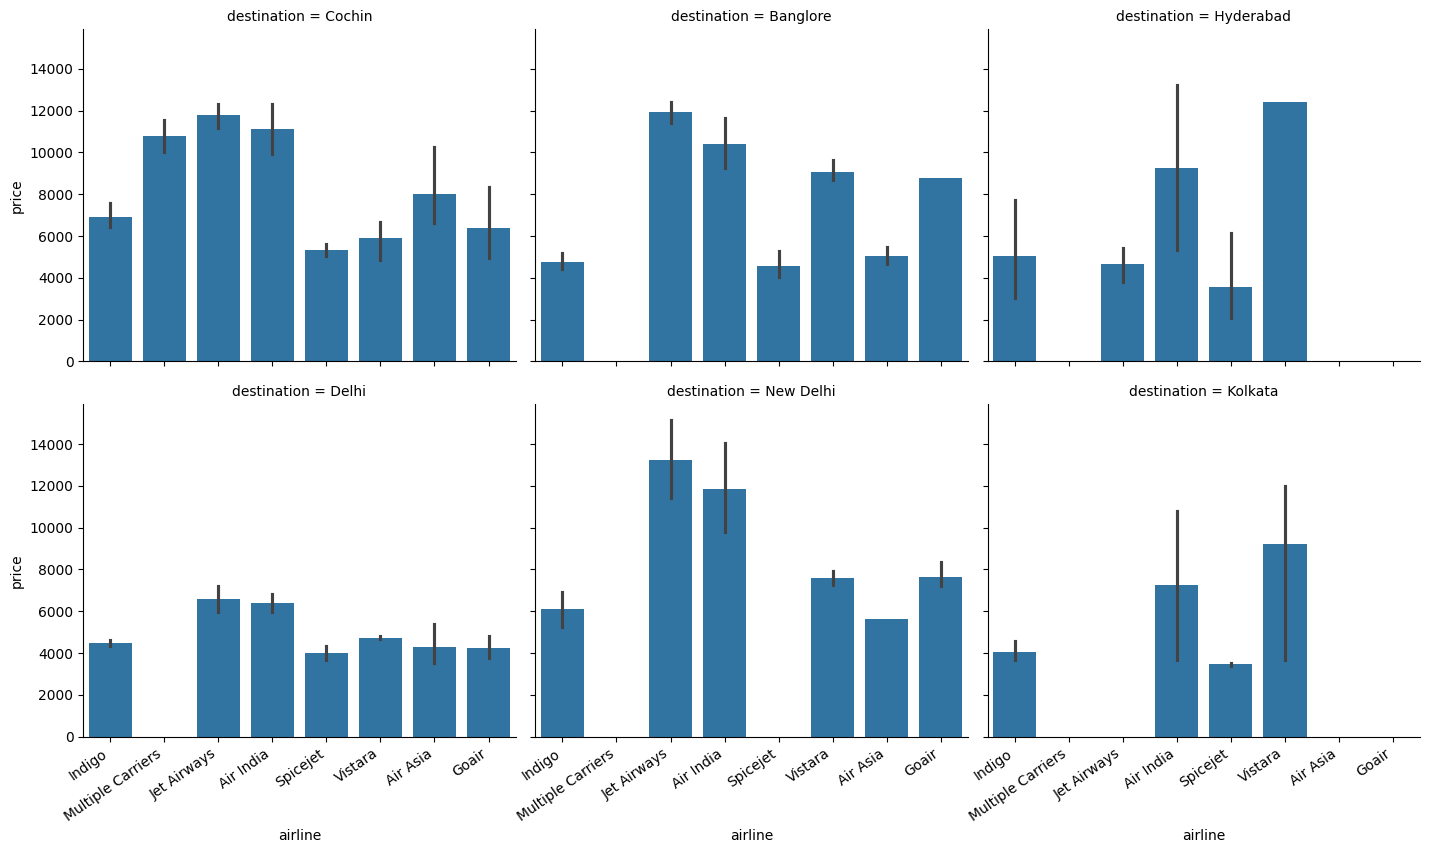

In [27]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_xlabels(ax)

>- So this was the beautty of FacetGrid we can do multivariate analysis.
>- In above plot we get that at each destinations we get the proce of airline.

### 8.2 date_of_journey

In [28]:
train.date_of_journey

0     2019-06-06
1     2019-06-15
2     2019-05-12
3     2019-05-09
4     2019-03-06
         ...    
635   2019-05-18
636   2019-05-21
637   2019-05-24
638   2019-06-12
639   2019-06-15
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

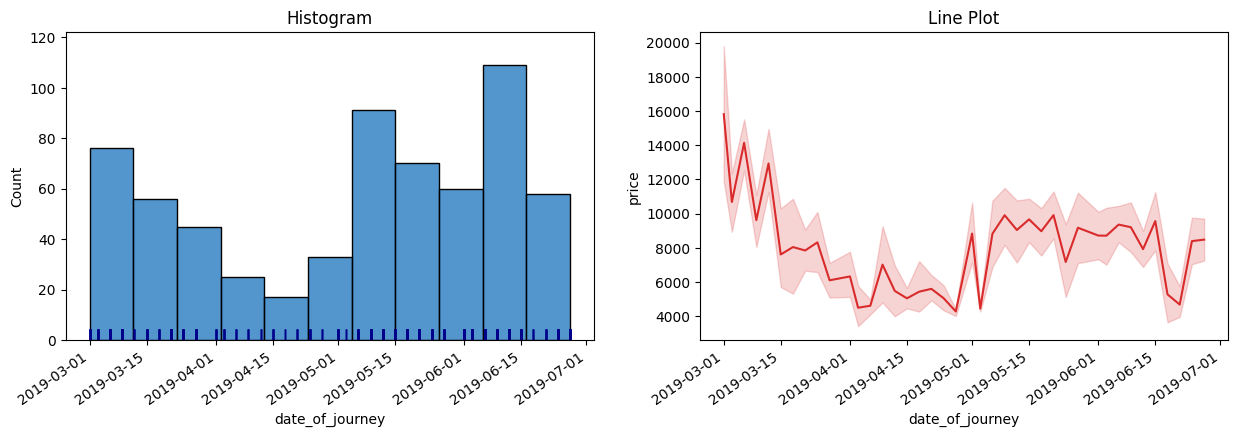

In [29]:
eda_helper_functions.dt_univar_plots(train,'date_of_journey','price')

>- For grouping datetime dtype we hhva eto use grouper from pandas lets see below
>- We can perform groupby and see monthwise price ticekt for flights by assigning freq = 'M' for daily we use d for weekly we can use w

<Figure size 1000x600 with 0 Axes>

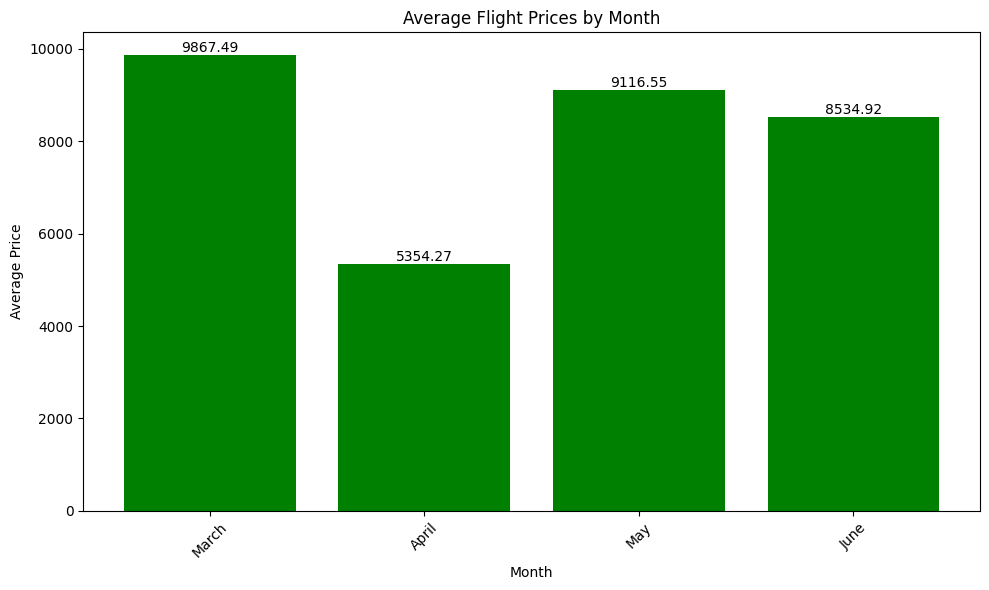

In [30]:
monthly_avg_price = (
    train
    .groupby(pd.Grouper(key='date_of_journey', freq='M'))
    .price.mean()
    .to_frame()
)

plt.figure(figsize=(10,6))

# Set custom axis labels
monthly_avg_price.index = ['March', 'April', 'May', 'June']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(monthly_avg_price.index, monthly_avg_price['price'], color='g')

# Adding labels to each bar
ax.bar_label(bars, fmt='%.2f');

ax.set_xlabel('Month')
ax.set_ylabel('Average Price')
ax.set_title('Average Flight Prices by Month')
plt.xticks(rotation=45)  # Keeping x labels horizontal
plt.tight_layout()

# Show plot
plt.show()

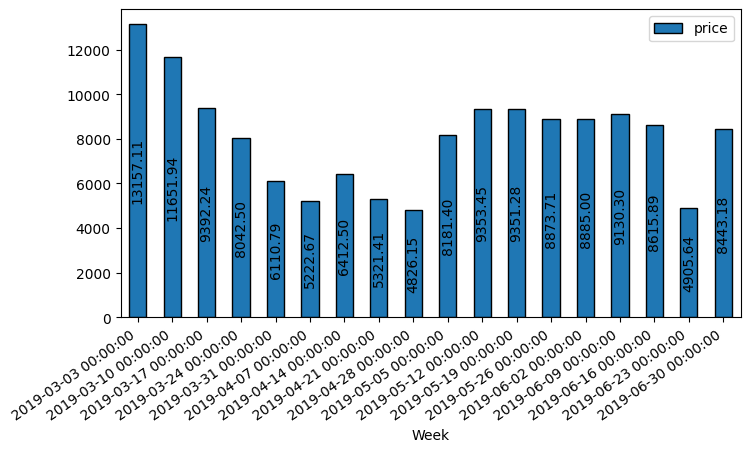

In [31]:
Weekly_FlightPrice=(
    train
    .groupby(pd.Grouper(key='date_of_journey', freq='w'))
    .price.mean()
    .to_frame()
    .rename_axis(index='Week')
    .plot(
        kind='bar',
        edgecolor='black',
        figsize=(8,4)
    )
)

ax = plt.gca()

# Get the BarContainer object from the bar plot
bars = ax.containers[0]

# Add labels to the bars
labels = ax.bar_label(bars, fmt='%.2f',label_type='center')

# Rotate the labels
for label in labels:
    label.set_rotation(90)
    label.set_verticalalignment('center')  # Adjust alignment as needed
    label.set_horizontalalignment('center')  # Adjust alignment as needed

eda_helper_functions.rotate_xlabels(ax)

plt.show()

In [32]:
# lets do multivariate analysis of monthly prices from where flight will take off.

(
    train
    .groupby([pd.Grouper(key = 'date_of_journey', freq ='M'), 'source'])
    .price.mean()
    .reset_index()
    .sort_values(by='price',ascending=True)
)

,date_of_journey,source,price
13,2019-05-31,Mumbai,2738.800000
18,2019-06-30,Mumbai,3762.833333
8,2019-04-30,Mumbai,4113.000000
15,2019-06-30,Chennai,4538.444444
10,2019-05-31,Chennai,4548.777778
9,2019-05-31,Banglore,4788.535714
5,2019-04-30,Banglore,5046.962963
1,2019-03-31,Chennai,5070.875000
7,2019-04-30,Kolkata,5190.866667
14,2019-06-30,Banglore,5422.945946


In [33]:
(
    train
    .groupby([pd.Grouper(key = 'date_of_journey', freq ='M'), 'source'])
    .price.mean()
    .unstack(fill_value=0)
)

source,Banglore,Chennai,Delhi,Kolkata,Mumbai
date_of_journey,,,,,
2019-03-31,10919.438596,5070.875000,11094.984127,7116.727273,7734.000000
2019-04-30,5046.962963,0.000000,6115.947368,5190.866667,4113.000000
2019-05-31,4788.535714,4548.777778,10821.343284,10057.282353,2738.800000
2019-06-30,5422.945946,4538.444444,10064.955752,9360.069767,3762.833333


>- Unstack were used to convert into pivot table 
>- As it converts series row index to column

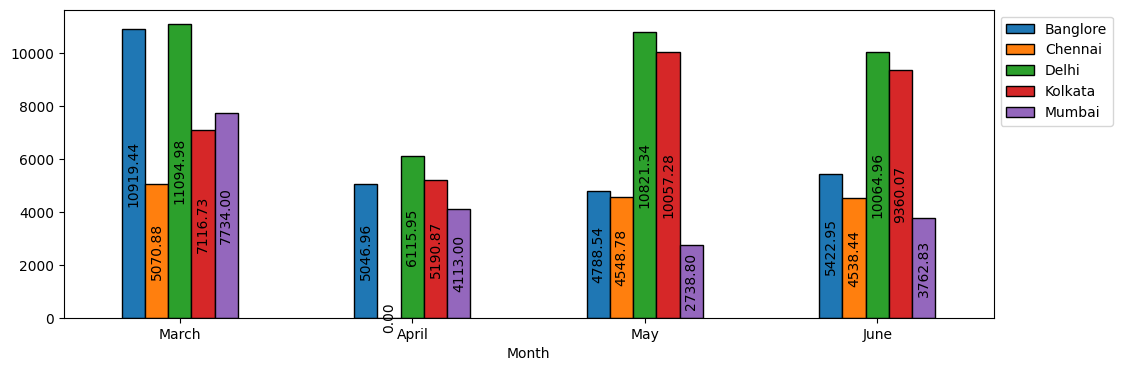

In [34]:
(
    train
    .groupby([pd.Grouper(key = 'date_of_journey', freq ='M'), 'source'])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(['March','April','May','June'])
    .rename_axis(index='Month')
    .plot(
        kind='bar',
        figsize=(12,4),
        edgecolor='Black'
    )
)

ax = plt.gca()

ax.legend(
    loc='upper left',
    bbox_to_anchor=(1,1)
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type='center', rotation=90)

plt.xticks(rotation=0)
plt.show()

### 8.3 dep_time

In [35]:
train.dep_time

0     2024-06-25 14:20:00
1     2024-06-25 11:30:00
2     2024-06-25 17:00:00
3     2024-06-25 14:25:00
4     2024-06-25 12:45:00
              ...        
635   2024-06-25 10:20:00
636   2024-06-25 08:00:00
637   2024-06-25 09:35:00
638   2024-06-25 07:10:00
639   2024-06-25 18:15:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

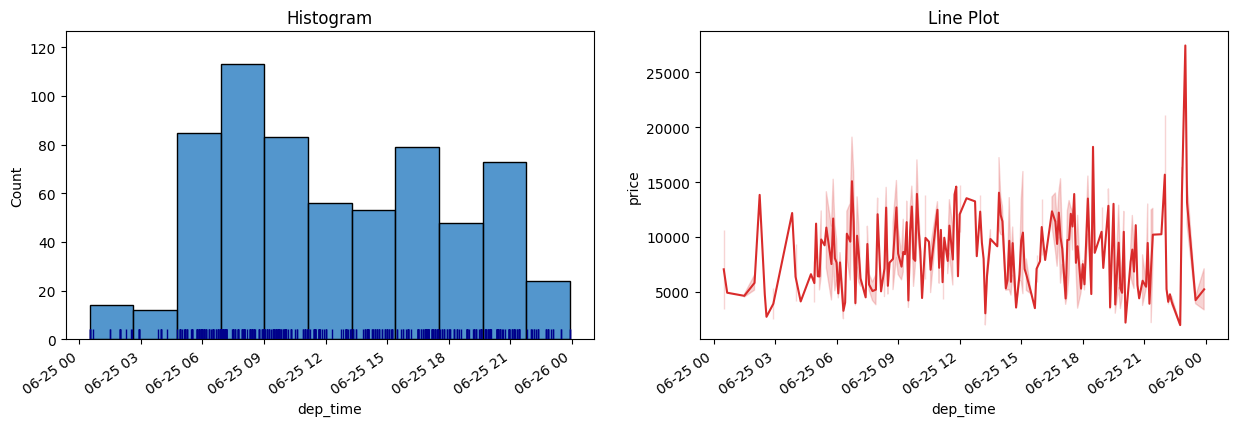

In [36]:
eda_helper_functions.dt_univar_plots(train, 'dep_time', 'price')

>- This plot showing that on 22 june from 12:00 AM to 3:00 AM and likewise how many flights were booked.
>- From 7 AM to 12 PM most of flights were get booked.
>- line plot showing tha Prices of flights in that one day correspoong to hrs.
>- Flights from 11 to 12 PM prices get high.

- lets use that hrs info and convert them into part of the day

In [37]:
(
    train
    .dep_time
    .dt.hour
    .pipe(lambda ser: pd.Series(np.select([ser.between(4,12, inclusive='left'),
                                 ser.between(12,16, inclusive='left'),
                                 ser.between(16,20, inclusive='left')],
                                ['morning',
                                 'afternoon',
                                 'evening'],
                                default='night')))
)

0      afternoon
1        morning
2        evening
3      afternoon
4      afternoon
         ...    
635      morning
636      morning
637      morning
638      morning
639      evening
Length: 640, dtype: object

>- Pipe were used to apply the function over data of series.
>- Pipe allows to apply function faster than apply method.
>- selct method of numy were used for complex selection based on multiple conditions.
>- It is sedful to choose multiple elements from arrays or data values to apply multiple condition.

>- apply is for applying functions along an axis (rows or columns) for element-wise transformations.
>- pipe is for applying functions to the whole DataFrame to chain operations and maintain readability.

>- where is for simple conditional replacements or filtering based on a single condition.
>- select is for more complex conditional replacements involving multiple conditions and corresponding choices.

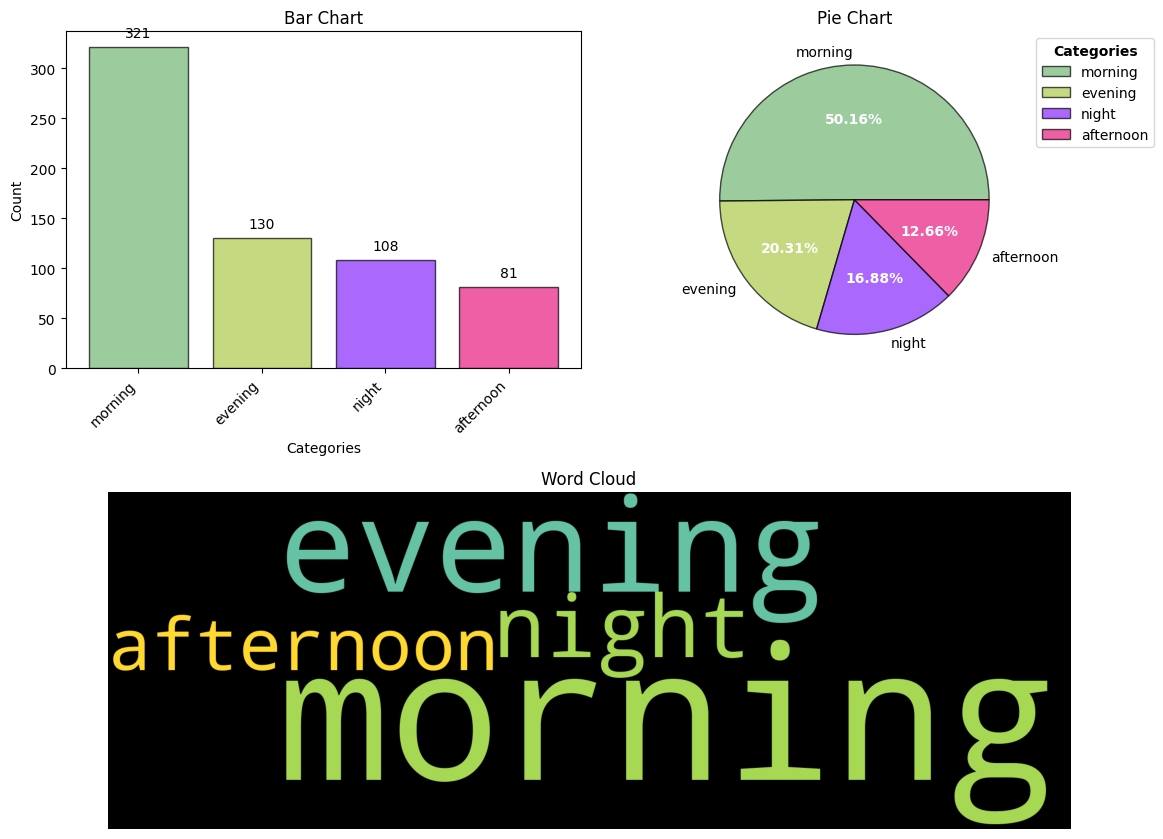

In [38]:
(
    train
    .assign(dep_time=lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4,12, inclusive='left'),
                   df_.dep_time.dt.hour.between(12,16, inclusive='left'),
                   df_.dep_time.dt.hour.between(16,20, inclusive='left')],
                   ['morning',
                    'afternoon',
                    'evening'],
                   default='night')))
    
    .pipe(eda_helper_functions.cat_univar_plots, 'dep_time')
)

>- From above plot we get that most of the flights booked on morning.

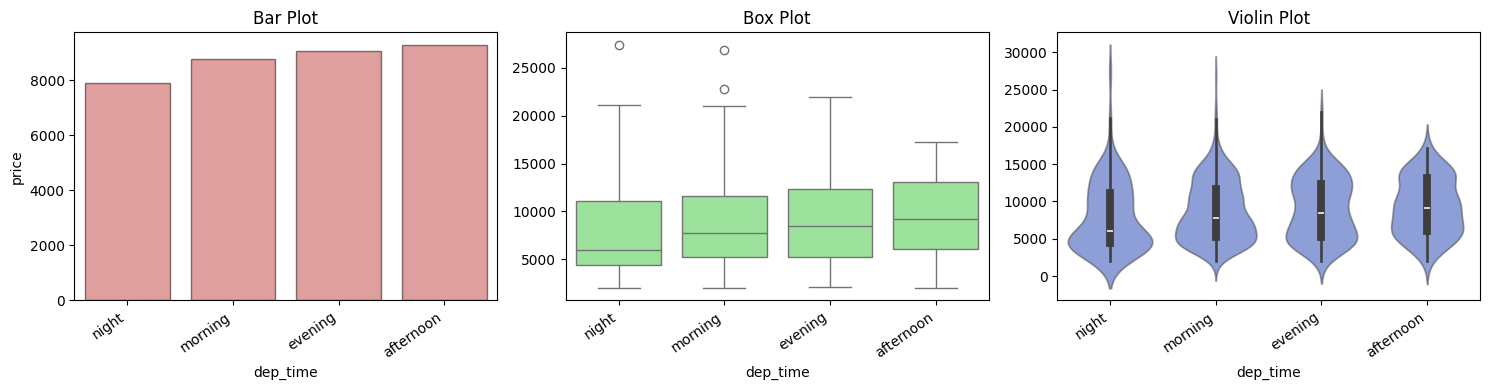

In [39]:
(
    train
    .assign(dep_time=lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4,12, inclusive='left'),
                   df_.dep_time.dt.hour.between(12,16, inclusive='left'),
                   df_.dep_time.dt.hour.between(16,20, inclusive='left')],
                   ['morning',
                    'afternoon',
                    'evening'],
                   default='night')))
    
    .pipe(eda_helper_functions.num_cat_bivar_plots, 'price','dep_time')
)

>- From bar plot we get that price of flights accoridng to its time.
>- In afternoon the price for flight is high as compare to rest of three.
>- If we see in box plot distribution of price in night and morning has some of prices are very high means they are different from there normal price value
>- If we see violne plot so we can get the shape of distribution of the data.

### 8.4 duration

In [40]:
(
    train
    .duration
)

0       490
1       465
2      1745
3      1730
4      1840
       ... 
635     520
636    1225
637    1450
638     175
639    1100
Name: duration, Length: 640, dtype: int64

In [41]:
# lets get the numeric summary 
eda_helper_functions.num_summary(train, 'duration')

0       490
1       465
2      1745
3      1730
4      1840
       ... 
635     520
636    1225
637    1450
638     175
639    1100
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,80.00
5,94.75
10,150.00
25,170.00
50,497.50
75,965.00
90,1445.00
95,1615.25
99,1800.00


,value
mean,638.132812
trimmed mean (5%),605.677083
trimmed mean (10%),576.240234
median,497.500000


,value
var,262254.450252
std,512.107850
IQR,795.000000
mad,332.500000
coef_variance,0.802510


,value
skewness,0.823703
kurtosis,-0.310745


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 8.538254814103602e-22
Test Statistic       : 0.8803769946098328
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 26.399599939389418
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


### Percnetiles

>- Percentile showing that lets talk about first row so it is indicating that shortest time of flight is 80 min in our dataset.
>- percentiles 0,5,10 means lets for 10 value is 150 --> it means for 10 percents of flight is nour dataset are less than 150 min.

### trimmed mean

>- As we know that mean is nothing but in this dataset accoridng to the duartion it shows avergae time of flights is 639 min.
>- But the mean is highly influenced by the outliers this cause change in the shape of distribution of data.
>- So we calculated trimmed mean of 5%. It means that 5 % of upper max values and lower min values was removed and takes the average mean of duration for flight.

### Measure of Spread

>- variance : is nothing but the how much data points are spread from there mean value.
>- std : it is sqaure root of variance standard deviation. It is an average distance of each data points from the mean.
>- standard deviation telling us that average distance of flights duration are 500 min + or - from the mean value. In between this range we have most of values

>- IQR : Inter Quartile Range --> It is an difference between 75th percentile of dustribution - 25th 
>- MAD : Median Abosolute Deviation --> 1) We calculate the median. 
                                        2) After from each datapoint we subatrct the median. 
                                        3) We calculate the absoute value of median.
                                        4) Finally we cal the median value for the absolute values.
>- We do these beacuse variance and std are impacted by outlier beacuse it cal average distance and differre from there avg value.

>- Outliers will impacted on mean , std and variance beacuse -->
>- mean : mean is sensitive because it is an average of all data points a single outlier makes shift in the mean value.
>- variance and std : variance amd std are senitive to the outlier beacuse they are squaring the differences from  mean.
>- IQR and MAD : Robust towards the outlier beacuse they focus on the middle portin of data.

>- coef of variance : standard deviation / mean

### Skweness and Kurtosis

>- So it is giving the value 0.82 means it is not 0 so comapred to normal distrivution data is skwewd towards the ositive side --> towards the rightside.
>- Kurtosis indicates the thickness of tails --> so -0.3 means peak will be small and small tails our data has.

### Hypothesis Testing

>- for normality it uses assumption testing --> making an inference over the population using sample data.
>- Shapiro wilk and Anderson Darling tests were used to meausre how well data points fits the normal distribution. 

>- From those steps we comfirmed that data is not normally dtributed

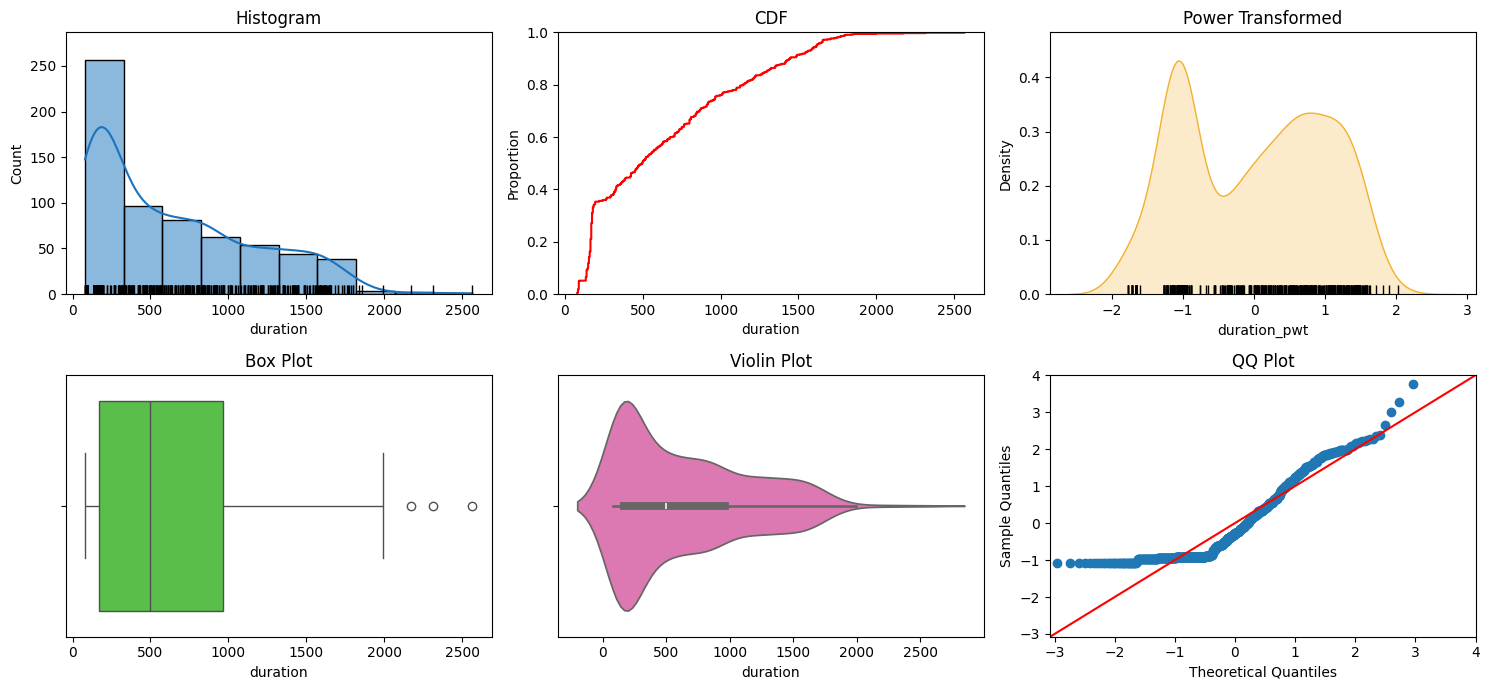

In [42]:
eda_helper_functions.num_univar_plots(train, 'duration')

>- Bar : From bar plot we get that most of the flights have short duration. But there are very few flights has long duration
    
>- CDF : Cumulative Distribution Function : CDF shows 0.0 - 0.1 value on y-axis and duration on x-axis. So lets say for 0.2 % corresponding duration time is 300 minutes.
        CDF saying that 20% of flights has duration less than 300 minutes acco. to our data.
        
>- Power Transformerd : It transformed feature as symmetric as possible it wont do normal distributed.

>- QQPlot : Qunatile - Quantile It shows that our data is following the therotical dstribution or not. So in above we can see that our data is not follwing the straight line so its not following theortical and it is not an normal distributed.

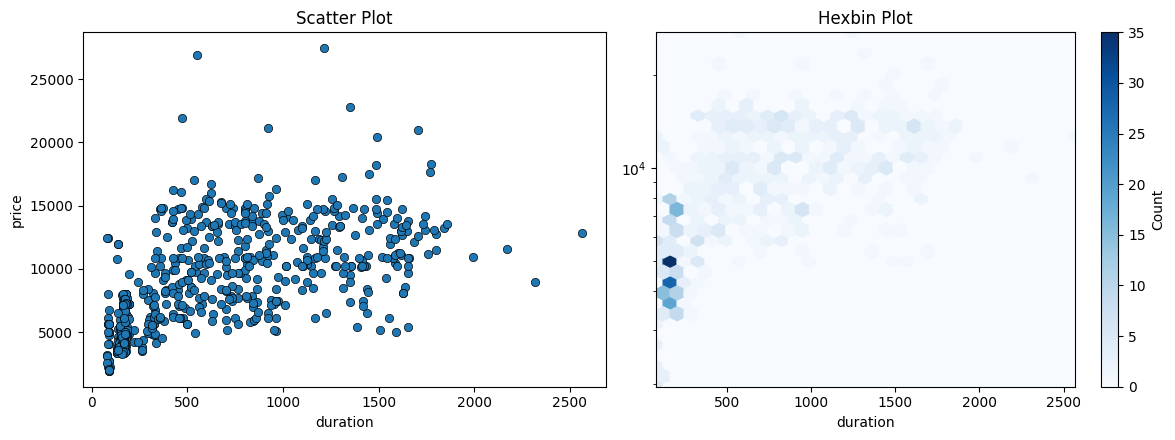

In [43]:
eda_helper_functions.num_bivar_plots(
    train,
    'duration',
    'price',
    hexbin_kwargs=dict(
        yscale='log',
        gridsize=30,
        cmap='Blues'
    )
)

>- hexbin : It shows the cpunt of values in specific hexbins hexagone range.
    So hexbin divides the data accordng to ranges in hexagone form and further it shows the count of values.

In [44]:
eda_helper_functions.num_num_hyp_testing(train, 'price', 'duration')

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6195881310606073
- p-value              : 4.048382502500982e-69
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.7292839096303014
- p-value              : 3.070475660371863e-107
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


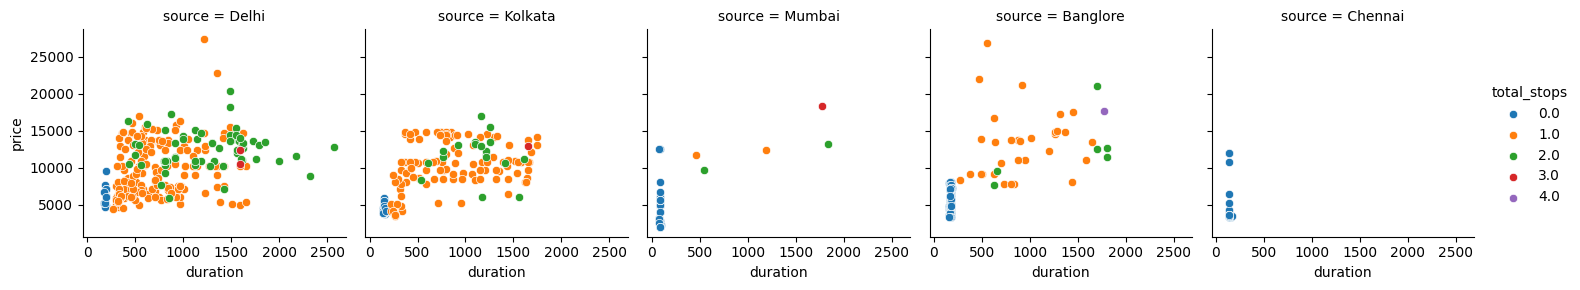

In [45]:
duration_grid = sns.FacetGrid(
    data=train,
    col='source',
    hue='total_stops',
    sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")
duration_grid.add_legend()

>- Above plot shows the price for each source and stops according to there duration.

In [49]:
eda_helper_functions.get_iqr_outliers(train, 'duration')

Lower Limit : -1022.5
Upper Limit : 2157.5


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
149,Air India,2019-03-03,Delhi,Cochin,2024-06-25 07:05:00,2024-06-25 19:15:00,2170,2.0,No Info,11552
242,Jet Airways,2019-03-27,Delhi,Cochin,2024-06-25 05:10:00,2024-06-25 19:45:00,2315,2.0,In-flight meal not included,8938
431,Jet Airways,2019-03-21,Delhi,Cochin,2024-06-25 09:40:00,2024-06-25 04:25:00,2565,2.0,No Info,12819


### 8.5 Additional Info

In [50]:
train.additional_info

0                          No Info
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636    In-flight meal not included
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [52]:
eda_helper_functions.cat_summary(train,'additional_info')

0                          No Info
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636    In-flight meal not included
637                        No Info
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 4 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,4
top,No Info
freq,500


,count,percentage
category,,
No Info,500,0.781250
In-flight meal not included,116,0.181250
No check-in baggage included,23,0.035937
Change airports,1,0.001563


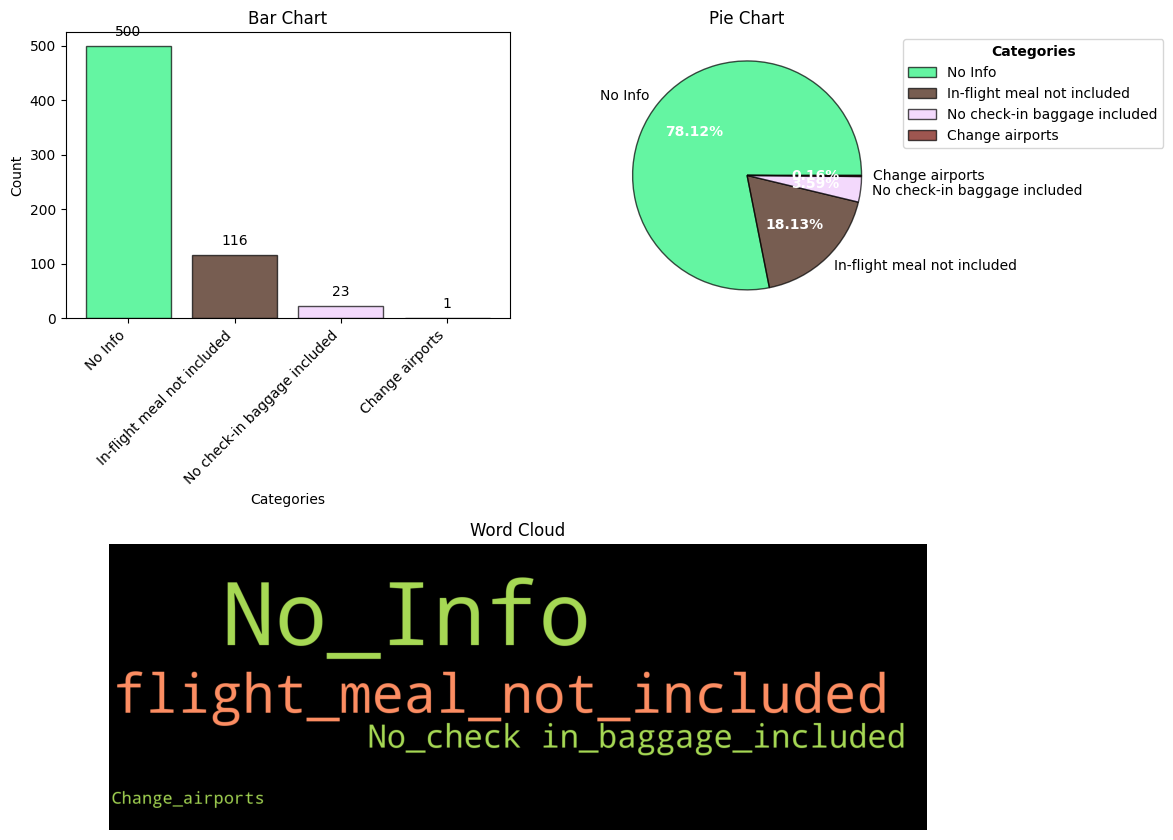

In [51]:
eda_helper_functions.cat_univar_plots(train, 'additional_info')

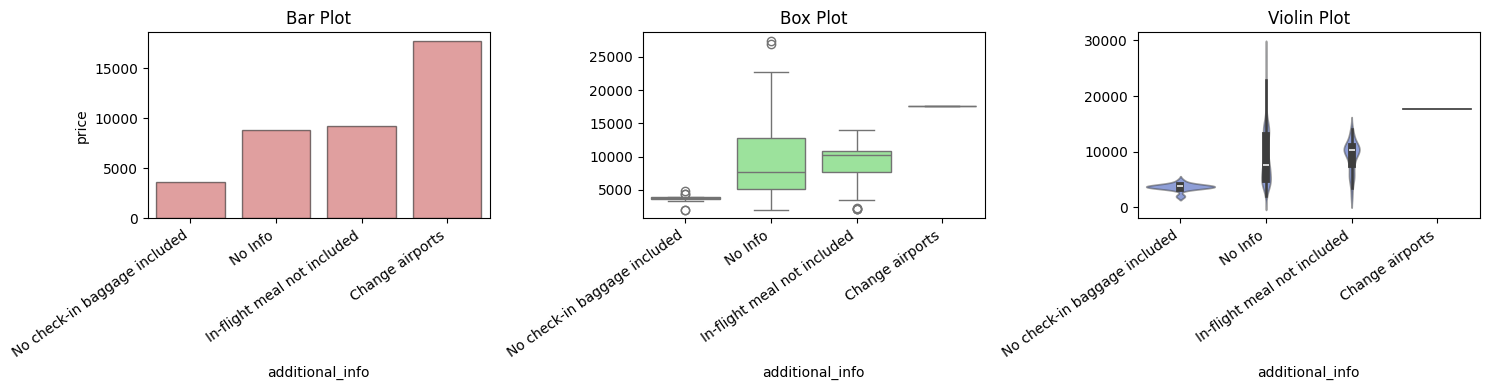

In [57]:
eda_helper_functions.num_cat_bivar_plots(train, 'price', 'additional_info')

>- Above plots shows the additional info according to the flights

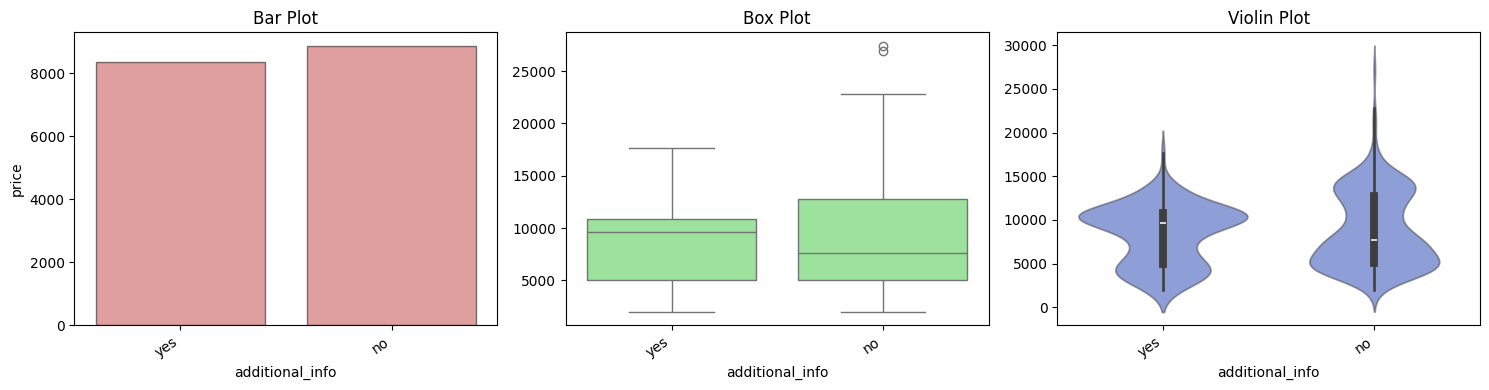

In [65]:
# convert additional info to the binary for analysis.

(
    train
    .assign(additional_info=
        
        train
        .additional_info
        .pipe(lambda ser: np.where(ser.eq('No Info'),'no',"yes"))
        
    )
    .pipe(eda_helper_functions.num_cat_bivar_plots, 'price', 'additional_info')
)

In [66]:
eda_helper_functions.num_cat_hyp_testing(train, 'price', 'additional_info')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 14.64664428498621
- p-value              : 3.109146906127578e-09
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and additional_info are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 57.255467178356405
- p-value              : 2.266614217553288e-12
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and additional_info are associated to each other
